In [1]:
import os
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm

c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Using device: ", device)

Using device:  cuda


In [3]:
def extract_class_id(image_name):
    """
    Image name example:
    0_1_BMW_X3_156 => 1
    2_4_Volkswagen_Polo_3471 => 24
    8_6_Ford_Focus_11936 => 86
    """
    image_name = image_name.split("/")[-1]
    image_name = image_name.split(".")[0]
    return int(image_name.split("_")[0] + image_name.split("_")[1])

In [4]:
#Load dataset
data_dir = '../../data/dataset'
#Set output path
output_path = "../../outputs/resnet34_2_steps_data_augmentation"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [5]:
items_per_class = 10
train_files = []
val_files = []
test_files = []

class_files = {}
for file in os.listdir(data_dir):
    class_id = extract_class_id(file)
    if class_id not in class_files:
        class_files[class_id] = []
    class_files[class_id].append(file)

for class_id in class_files:
    np.random.shuffle(class_files[class_id])
    test_files += class_files[class_id][:items_per_class]   
    val_files += class_files[class_id][items_per_class:2*items_per_class]
    train_files += class_files[class_id][2*items_per_class:]       
    

#Check if there is not overlap between the sets
assert len(set(train_files).intersection(set(val_files))) == 0
assert len(set(train_files).intersection(set(test_files))) == 0
assert len(set(val_files).intersection(set(test_files))) == 0

print(len(train_files), len(val_files), len(test_files))

8065 960 960


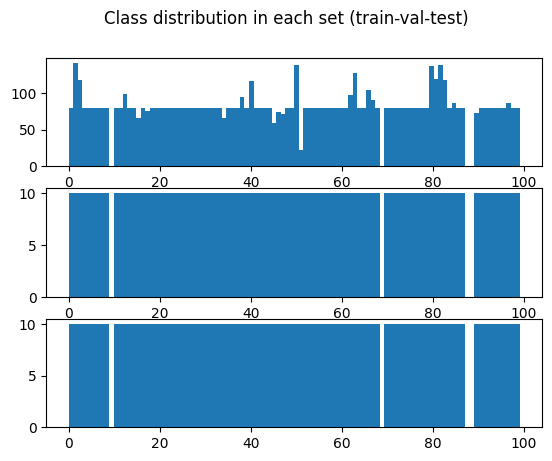

In [6]:
#Display class distribution in each set
train_class_distribution = [extract_class_id(file) for file in train_files]
val_class_distribution = [extract_class_id(file) for file in val_files]
test_class_distribution = [extract_class_id(file) for file in test_files]


fig, axs = plt.subplots(3)
fig.suptitle('Class distribution in each set (train-val-test)')
axs[0].hist(train_class_distribution, bins=100)
axs[1].hist(val_class_distribution, bins=100)
axs[2].hist(test_class_distribution, bins=100)
plt.savefig(os.path.join(output_path, "class_distribution.png"))

In [7]:
class Car_Dataset(Dataset):
    def __init__(self, data_dir, files, split = "train"):
        self.data_dir = data_dir
        self.data = files

        if split == "train":
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),            
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file = self.data[idx]
        label = file.split('_')[0] + file.split('_')[1]
        label = int(label)
        label = torch.eye(100)[label]
        
        img = Image.open(os.path.join(self.data_dir, file)).convert('RGB')
        img = self.transform(img)

        return {"image" : img, "label" : label}

In [8]:
train_dataset = Car_Dataset(data_dir, train_files, split = "train")
val_dataset = Car_Dataset(data_dir, val_files, split = "val")
test_dataset = Car_Dataset(data_dir, test_files, split = "test")

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [10]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True).to(device)
model.fc = torch.nn.Linear(512, 100).to(device)
for param in model.parameters():
    param.requires_grad = False

Using cache found in C:\Users\cleme/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def evaluate(dataloader, model, loss_fn):
    model.eval()
    predicted_labels = []
    true_labels = []
    losses = []
    with torch.no_grad():
        for data in dataloader:
            X, y = data['image'], data['label']
            pred = model(X.to(device))
            loss = loss_fn(pred, y.to(device))
            predicted_labels.extend(pred.argmax(1).tolist())
            true_labels.extend(y.argmax(1).tolist())
            losses.append(loss.item())
    
    return np.array(predicted_labels), np.array(true_labels), np.mean(losses)

In [12]:
def train_loop(train_loader, val_loader, model, loss_fn, optimizer, n_epoch, patience=5):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    print("Training model...")
    best_val_metric = 0
    patience_counter = 0
    best_model = model
    for epoch in tqdm(range(n_epoch)):
        model.train()
        for data in train_loader:
            X, y = data['image'], data['label']
            pred = model(X.to(device))
            #pred = pred.logits #Needed for inception
            loss = loss_fn(pred, y.to(device))        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        predicted_labels, true_labels, train_loss = evaluate(train_loader, model, loss_fn)
        print("Epoch: ", epoch, " Training Loss: ", train_loss)
        print("Epoch: ", epoch, " Training Accuracy: ", np.mean(predicted_labels == true_labels))
        training_losses.append(train_loss)
        training_accuracies.append(np.mean(predicted_labels == true_labels))
        
        predicted_labels, true_labels, val_loss = evaluate(val_loader, model, loss_fn)
        print("Epoch: ", epoch, " Validation Loss: ", val_loss)
        print("Epoch: ", epoch, " Validation Accuracy: ", np.mean(predicted_labels == true_labels))
        validation_losses.append(val_loss)
        validation_accuracies.append(np.mean(predicted_labels == true_labels))

        if np.mean(predicted_labels == true_labels) > best_val_metric:
            best_val_metric = np.mean(predicted_labels == true_labels)
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter == patience:
                print("Early stopping...")
                break

    #Save model
    return best_model, training_losses, validation_losses, training_accuracies, validation_accuracies

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.0001)
for param in model.fc.parameters():
        param.requires_grad = True
print("Step 1 training")
step1_best_model, step1_training_losses, step1_validation_losses, step1_training_accuracies, step1_validation_accuracies = train_loop(train_dataloader, val_dataloader, model, loss_fn, optimizer, 100, 5)
torch.save(step1_best_model.state_dict(), os.path.join(output_path, "step1_model.pth"))

Step 1 training
Training model...


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:  0  Training Loss:  3.7610324718128294
Epoch:  0  Training Accuracy:  0.15536267823930563


  1%|          | 1/100 [02:35<4:16:21, 155.37s/it]

Epoch:  0  Validation Loss:  3.9982121735811234
Epoch:  0  Validation Accuracy:  0.10625
Epoch:  1  Training Loss:  3.556358150254989
Epoch:  1  Training Accuracy:  0.1864848109113453


  2%|▏         | 2/100 [05:11<4:14:54, 156.07s/it]

Epoch:  1  Validation Loss:  3.9627237901091577
Epoch:  1  Validation Accuracy:  0.14375
Epoch:  2  Training Loss:  3.3213545530517323
Epoch:  2  Training Accuracy:  0.2301301921884687


  3%|▎         | 3/100 [07:50<4:13:57, 157.09s/it]

Epoch:  2  Validation Loss:  3.8155928805470465
Epoch:  2  Validation Accuracy:  0.17291666666666666
Epoch:  3  Training Loss:  3.0648179110998437
Epoch:  3  Training Accuracy:  0.26447613143211407


  4%|▍         | 4/100 [10:26<4:10:54, 156.82s/it]

Epoch:  3  Validation Loss:  3.6355190709233285
Epoch:  3  Validation Accuracy:  0.17708333333333334
Epoch:  4  Training Loss:  3.029469170012448
Epoch:  4  Training Accuracy:  0.28158710477371357


  5%|▌         | 5/100 [12:52<4:01:48, 152.72s/it]

Epoch:  4  Validation Loss:  3.631030855079492
Epoch:  4  Validation Accuracy:  0.18333333333333332
Epoch:  5  Training Loss:  3.1134323653278813
Epoch:  5  Training Accuracy:  0.27042777433354


  6%|▌         | 6/100 [15:16<3:55:01, 150.02s/it]

Epoch:  5  Validation Loss:  3.7404540151357653
Epoch:  5  Validation Accuracy:  0.17708333333333334
Epoch:  6  Training Loss:  3.061441880807347
Epoch:  6  Training Accuracy:  0.2861748295102294


  7%|▋         | 7/100 [17:42<3:50:08, 148.48s/it]

Epoch:  6  Validation Loss:  3.6369202320774394
Epoch:  6  Validation Accuracy:  0.19166666666666668
Epoch:  7  Training Loss:  2.9283982571482245
Epoch:  7  Training Accuracy:  0.3050216986980781


  8%|▊         | 8/100 [20:06<3:45:40, 147.18s/it]

Epoch:  7  Validation Loss:  3.6974456533789635
Epoch:  7  Validation Accuracy:  0.18854166666666666
Epoch:  8  Training Loss:  2.978879684526021
Epoch:  8  Training Accuracy:  0.30291382517048976


  9%|▉         | 9/100 [22:31<3:42:00, 146.38s/it]

Epoch:  8  Validation Loss:  3.6874377496540545
Epoch:  8  Validation Accuracy:  0.22604166666666667
Epoch:  9  Training Loss:  2.9331084606697138
Epoch:  9  Training Accuracy:  0.3226286422814631


 10%|█         | 10/100 [24:55<3:38:44, 145.83s/it]

Epoch:  9  Validation Loss:  3.6282360506554445
Epoch:  9  Validation Accuracy:  0.21458333333333332
Epoch:  10  Training Loss:  2.899347768822222
Epoch:  10  Training Accuracy:  0.3161810291382517


 11%|█         | 11/100 [27:20<3:35:48, 145.49s/it]

Epoch:  10  Validation Loss:  3.7430980771780016
Epoch:  10  Validation Accuracy:  0.21458333333333332
Epoch:  11  Training Loss:  2.8775446782415908
Epoch:  11  Training Accuracy:  0.32523248605083693


 12%|█▏        | 12/100 [29:44<3:32:55, 145.18s/it]

Epoch:  11  Validation Loss:  3.5764251408477623
Epoch:  11  Validation Accuracy:  0.221875
Epoch:  12  Training Loss:  2.8588967730194685
Epoch:  12  Training Accuracy:  0.3407315561066336


 13%|█▎        | 13/100 [32:09<3:30:16, 145.01s/it]

Epoch:  12  Validation Loss:  3.814033637444178
Epoch:  12  Validation Accuracy:  0.21770833333333334
Epoch:  13  Training Loss:  2.832896920271037
Epoch:  13  Training Accuracy:  0.3323000619962802


 13%|█▎        | 13/100 [34:35<3:51:28, 159.64s/it]

Epoch:  13  Validation Loss:  3.794285098214944
Epoch:  13  Validation Accuracy:  0.2125
Early stopping...


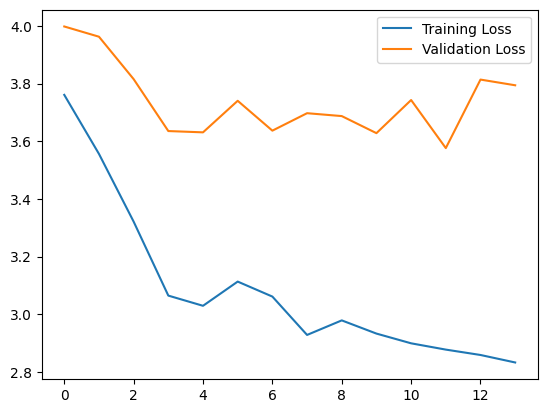

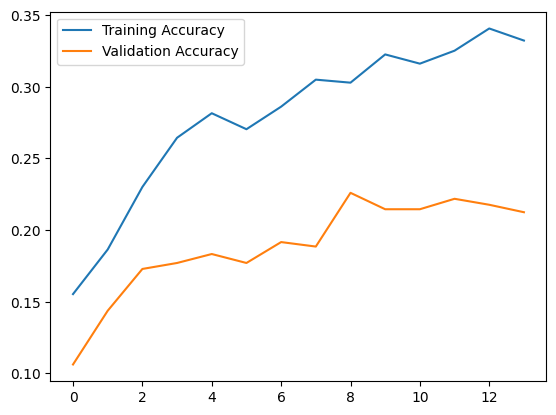

In [14]:
#plot learning curves
plt.figure()
plt.plot(step1_training_losses, label='Training Loss')
plt.plot(step1_validation_losses, label='Validation Loss')
plt.legend()
plt.savefig(os.path.join(output_path, "step1_loss.png"))

plt.figure()
plt.plot(step1_training_accuracies, label='Training Accuracy')
plt.plot(step1_validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.savefig(os.path.join(output_path, "step1_accuracy.png"))

In [15]:
for param in step1_best_model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(step1_best_model.parameters(), lr=0.0001, weight_decay=0.0001)
print("Step 2 training")
step2_best_model, step2_training_losses, step2_validation_losses, step2_training_accuracies, step2_validation_accuracies = train_loop(train_dataloader, val_dataloader, step1_best_model, loss_fn, optimizer, 100, 10)
torch.save(step2_best_model.state_dict(), os.path.join(output_path, "step2_model.pth"))


Step 2 training
Training model...


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:  0  Training Loss:  1.3107019239555477
Epoch:  0  Training Accuracy:  0.6198388096714197


  1%|          | 1/100 [02:54<4:48:01, 174.56s/it]

Epoch:  0  Validation Loss:  1.5753912839417656
Epoch:  0  Validation Accuracy:  0.5666666666666667
Epoch:  1  Training Loss:  1.0194643064136604
Epoch:  1  Training Accuracy:  0.6926224426534408


  2%|▏         | 2/100 [05:49<4:45:09, 174.59s/it]

Epoch:  1  Validation Loss:  1.325309510649337
Epoch:  1  Validation Accuracy:  0.640625
Epoch:  2  Training Loss:  0.7241337105128709
Epoch:  2  Training Accuracy:  0.768753874767514


  3%|▎         | 3/100 [08:45<4:43:23, 175.29s/it]

Epoch:  2  Validation Loss:  1.188392992079025
Epoch:  2  Validation Accuracy:  0.6572916666666667
Epoch:  3  Training Loss:  0.6981660501525151
Epoch:  3  Training Accuracy:  0.7820210787352759


  4%|▍         | 4/100 [11:39<4:40:00, 175.01s/it]

Epoch:  3  Validation Loss:  1.0228182949552622
Epoch:  3  Validation Accuracy:  0.7135416666666666
Epoch:  4  Training Loss:  0.5130443580086569
Epoch:  4  Training Accuracy:  0.8333539987600744


  5%|▌         | 5/100 [14:34<4:36:52, 174.87s/it]

Epoch:  4  Validation Loss:  0.89686791478404
Epoch:  4  Validation Accuracy:  0.753125
Epoch:  5  Training Loss:  0.4756442897334319
Epoch:  5  Training Accuracy:  0.847489150650961


  6%|▌         | 6/100 [17:30<4:34:40, 175.32s/it]

Epoch:  5  Validation Loss:  0.9501389215512366
Epoch:  5  Validation Accuracy:  0.75
Epoch:  6  Training Loss:  0.4128274946809232
Epoch:  6  Training Accuracy:  0.861128332300062


  7%|▋         | 7/100 [20:25<4:31:23, 175.09s/it]

Epoch:  6  Validation Loss:  0.8752742906741332
Epoch:  6  Validation Accuracy:  0.75
Epoch:  7  Training Loss:  0.338950488487558
Epoch:  7  Training Accuracy:  0.8889026658400496


  8%|▊         | 8/100 [23:19<4:28:07, 174.86s/it]

Epoch:  7  Validation Loss:  0.7384455109439538
Epoch:  7  Validation Accuracy:  0.80625
Epoch:  8  Training Loss:  0.32177383676839877
Epoch:  8  Training Accuracy:  0.889026658400496


  9%|▉         | 9/100 [26:15<4:25:45, 175.22s/it]

Epoch:  8  Validation Loss:  0.7832268622726588
Epoch:  8  Validation Accuracy:  0.79375
Epoch:  9  Training Loss:  0.2811812006431635
Epoch:  9  Training Accuracy:  0.9060136391816491


 10%|█         | 10/100 [29:10<4:22:37, 175.08s/it]

Epoch:  9  Validation Loss:  0.8119911886726641
Epoch:  9  Validation Accuracy:  0.78125
Epoch:  10  Training Loss:  0.31772635642047087
Epoch:  10  Training Accuracy:  0.8944823310601364


 11%|█         | 11/100 [32:04<4:19:25, 174.89s/it]

Epoch:  10  Validation Loss:  0.8277231629422507
Epoch:  10  Validation Accuracy:  0.7958333333333333
Epoch:  11  Training Loss:  0.21518216418489655
Epoch:  11  Training Accuracy:  0.9278363298202108


 12%|█▏        | 12/100 [35:00<4:16:52, 175.15s/it]

Epoch:  11  Validation Loss:  0.7584268110610007
Epoch:  11  Validation Accuracy:  0.8052083333333333
Epoch:  12  Training Loss:  0.24102612546284138
Epoch:  12  Training Accuracy:  0.921264724116553


 13%|█▎        | 13/100 [37:50<4:11:38, 173.54s/it]

Epoch:  12  Validation Loss:  0.7640839760497481
Epoch:  12  Validation Accuracy:  0.79375
Epoch:  13  Training Loss:  0.26649484137088525
Epoch:  13  Training Accuracy:  0.9128332300061996


 14%|█▍        | 14/100 [40:36<4:05:17, 171.14s/it]

Epoch:  13  Validation Loss:  0.8352016492864701
Epoch:  13  Validation Accuracy:  0.7958333333333333
Epoch:  14  Training Loss:  0.19644403212555275
Epoch:  14  Training Accuracy:  0.9375077495350279


 15%|█▌        | 15/100 [43:21<3:59:53, 169.33s/it]

Epoch:  14  Validation Loss:  0.7587444620740522
Epoch:  14  Validation Accuracy:  0.7979166666666667
Epoch:  15  Training Loss:  0.19675231751126404
Epoch:  15  Training Accuracy:  0.934531928084315


 16%|█▌        | 16/100 [46:06<3:55:29, 168.20s/it]

Epoch:  15  Validation Loss:  0.7325972039163408
Epoch:  15  Validation Accuracy:  0.821875
Epoch:  16  Training Loss:  0.2203398589595619
Epoch:  16  Training Accuracy:  0.928580285182889


 17%|█▋        | 17/100 [48:52<3:51:35, 167.42s/it]

Epoch:  16  Validation Loss:  0.8886464203742346
Epoch:  16  Validation Accuracy:  0.7875
Epoch:  17  Training Loss:  0.19432797495769
Epoch:  17  Training Accuracy:  0.9356478611283323


 18%|█▊        | 18/100 [51:38<3:48:05, 166.90s/it]

Epoch:  17  Validation Loss:  0.8318881092583978
Epoch:  17  Validation Accuracy:  0.803125
Epoch:  18  Training Loss:  0.14490393975471072
Epoch:  18  Training Accuracy:  0.9533787972721637


 19%|█▉        | 19/100 [54:23<3:44:47, 166.51s/it]

Epoch:  18  Validation Loss:  0.7902022168198145
Epoch:  18  Validation Accuracy:  0.81875
Epoch:  19  Training Loss:  0.14697823035741853
Epoch:  19  Training Accuracy:  0.9508989460632362


 20%|██        | 20/100 [57:09<3:41:37, 166.22s/it]

Epoch:  19  Validation Loss:  0.7203328640662235
Epoch:  19  Validation Accuracy:  0.8208333333333333
Epoch:  20  Training Loss:  0.19017891282339702
Epoch:  20  Training Accuracy:  0.937879727216367


 21%|██        | 21/100 [59:54<3:38:40, 166.08s/it]

Epoch:  20  Validation Loss:  0.8101052016476407
Epoch:  20  Validation Accuracy:  0.8197916666666667
Epoch:  21  Training Loss:  0.1773404774476642
Epoch:  21  Training Accuracy:  0.9417234965902046


 22%|██▏       | 22/100 [1:02:40<3:35:46, 165.99s/it]

Epoch:  21  Validation Loss:  0.7822773832361805
Epoch:  21  Validation Accuracy:  0.815625
Epoch:  22  Training Loss:  0.15284925960770573
Epoch:  22  Training Accuracy:  0.9537507749535028


 23%|██▎       | 23/100 [1:05:26<3:32:57, 165.95s/it]

Epoch:  22  Validation Loss:  0.7724381118615185
Epoch:  22  Validation Accuracy:  0.8166666666666667
Epoch:  23  Training Loss:  0.13711063256556164
Epoch:  23  Training Accuracy:  0.9530068195908246


 24%|██▍       | 24/100 [1:08:12<3:30:07, 165.89s/it]

Epoch:  23  Validation Loss:  0.7374612600850015
Epoch:  23  Validation Accuracy:  0.8322916666666667
Epoch:  24  Training Loss:  0.14962027578405782
Epoch:  24  Training Accuracy:  0.9528828270303782


 25%|██▌       | 25/100 [1:10:58<3:27:19, 165.86s/it]

Epoch:  24  Validation Loss:  0.7765993077845202
Epoch:  24  Validation Accuracy:  0.809375
Epoch:  25  Training Loss:  0.13837886970289026
Epoch:  25  Training Accuracy:  0.9549907005579665


 26%|██▌       | 26/100 [1:13:43<3:24:30, 165.81s/it]

Epoch:  25  Validation Loss:  0.718795664630655
Epoch:  25  Validation Accuracy:  0.821875
Epoch:  26  Training Loss:  0.16502206776496872
Epoch:  26  Training Accuracy:  0.9460632362058277


 27%|██▋       | 27/100 [1:16:29<3:21:39, 165.75s/it]

Epoch:  26  Validation Loss:  0.7880036456021647
Epoch:  26  Validation Accuracy:  0.81875
Epoch:  27  Training Loss:  0.1254921360770977
Epoch:  27  Training Accuracy:  0.958462492250465


 28%|██▊       | 28/100 [1:19:15<3:18:51, 165.72s/it]

Epoch:  27  Validation Loss:  0.7569675779273136
Epoch:  27  Validation Accuracy:  0.825
Epoch:  28  Training Loss:  0.13782818205130942
Epoch:  28  Training Accuracy:  0.9597024178549287


 29%|██▉       | 29/100 [1:22:00<3:16:05, 165.70s/it]

Epoch:  28  Validation Loss:  0.8169126820527367
Epoch:  28  Validation Accuracy:  0.828125
Epoch:  29  Training Loss:  0.1136568453397466
Epoch:  29  Training Accuracy:  0.9644141351518909


 30%|███       | 30/100 [1:24:46<3:13:16, 165.67s/it]

Epoch:  29  Validation Loss:  0.7186421554037415
Epoch:  29  Validation Accuracy:  0.8447916666666667
Epoch:  30  Training Loss:  0.138116385239679
Epoch:  30  Training Accuracy:  0.956478611283323


 31%|███       | 31/100 [1:27:31<3:10:30, 165.65s/it]

Epoch:  30  Validation Loss:  0.8858699004635201
Epoch:  30  Validation Accuracy:  0.821875
Epoch:  31  Training Loss:  0.12411796853895708
Epoch:  31  Training Accuracy:  0.9609423434593924


 32%|███▏      | 32/100 [1:30:17<3:07:40, 165.60s/it]

Epoch:  31  Validation Loss:  0.7840316593510425
Epoch:  31  Validation Accuracy:  0.8385416666666666
Epoch:  32  Training Loss:  0.10923717135282937
Epoch:  32  Training Accuracy:  0.9632982021078735


 33%|███▎      | 33/100 [1:33:03<3:04:54, 165.59s/it]

Epoch:  32  Validation Loss:  0.8812816272666167
Epoch:  32  Validation Accuracy:  0.8114583333333333
Epoch:  33  Training Loss:  0.1245468203133285
Epoch:  33  Training Accuracy:  0.9613143211407316


 34%|███▍      | 34/100 [1:35:48<3:02:15, 165.69s/it]

Epoch:  33  Validation Loss:  0.7969816800387222
Epoch:  33  Validation Accuracy:  0.8291666666666667
Epoch:  34  Training Loss:  0.14948793184779027
Epoch:  34  Training Accuracy:  0.9541227526348419


 35%|███▌      | 35/100 [1:38:34<2:59:30, 165.70s/it]

Epoch:  34  Validation Loss:  0.7892565811036524
Epoch:  34  Validation Accuracy:  0.8333333333333334
Epoch:  35  Training Loss:  0.13577336081778407
Epoch:  35  Training Accuracy:  0.9601983880967142


 36%|███▌      | 36/100 [1:41:20<2:56:48, 165.76s/it]

Epoch:  35  Validation Loss:  0.8317601054628431
Epoch:  35  Validation Accuracy:  0.8166666666666667
Epoch:  36  Training Loss:  0.11821921610091038
Epoch:  36  Training Accuracy:  0.9641661500309981


 37%|███▋      | 37/100 [1:44:06<2:54:02, 165.75s/it]

Epoch:  36  Validation Loss:  0.7946864670450291
Epoch:  36  Validation Accuracy:  0.8322916666666667
Epoch:  37  Training Loss:  0.09339908388442751
Epoch:  37  Training Accuracy:  0.9701177929324241


 38%|███▊      | 38/100 [1:46:52<2:51:16, 165.75s/it]

Epoch:  37  Validation Loss:  0.750295607578281
Epoch:  37  Validation Accuracy:  0.8510416666666667
Epoch:  38  Training Loss:  0.11426352362687987
Epoch:  38  Training Accuracy:  0.9654060756354619


 39%|███▉      | 39/100 [1:49:37<2:48:33, 165.80s/it]

Epoch:  38  Validation Loss:  0.708949759689728
Epoch:  38  Validation Accuracy:  0.8458333333333333
Epoch:  39  Training Loss:  0.09698800140573499
Epoch:  39  Training Accuracy:  0.9712337259764414


 40%|████      | 40/100 [1:52:23<2:45:47, 165.79s/it]

Epoch:  39  Validation Loss:  0.7286388723631421
Epoch:  39  Validation Accuracy:  0.846875
Epoch:  40  Training Loss:  0.08825192826590268
Epoch:  40  Training Accuracy:  0.972101673899566


 41%|████      | 41/100 [1:55:09<2:43:00, 165.78s/it]

Epoch:  40  Validation Loss:  0.9065482694212534
Epoch:  40  Validation Accuracy:  0.8104166666666667
Epoch:  41  Training Loss:  0.10237393475334305
Epoch:  41  Training Accuracy:  0.9678859268443893


 42%|████▏     | 42/100 [1:57:55<2:40:13, 165.76s/it]

Epoch:  41  Validation Loss:  0.8579509722232925
Epoch:  41  Validation Accuracy:  0.8291666666666667
Epoch:  42  Training Loss:  0.10392930686864317
Epoch:  42  Training Accuracy:  0.9683818970861748


 43%|████▎     | 43/100 [2:00:41<2:37:31, 165.82s/it]

Epoch:  42  Validation Loss:  0.8318211197332893
Epoch:  42  Validation Accuracy:  0.8375
Epoch:  43  Training Loss:  0.09835037892073693
Epoch:  43  Training Accuracy:  0.9702417854928704


 44%|████▍     | 44/100 [2:03:26<2:34:46, 165.83s/it]

Epoch:  43  Validation Loss:  0.8026693781428555
Epoch:  43  Validation Accuracy:  0.8479166666666667
Epoch:  44  Training Loss:  0.09307497318579312
Epoch:  44  Training Accuracy:  0.9728456292622443


 45%|████▌     | 45/100 [2:06:12<2:32:01, 165.85s/it]

Epoch:  44  Validation Loss:  0.7480751169622277
Epoch:  44  Validation Accuracy:  0.840625
Epoch:  45  Training Loss:  0.08539021776429503
Epoch:  45  Training Accuracy:  0.974085554866708


 46%|████▌     | 46/100 [2:08:58<2:29:15, 165.84s/it]

Epoch:  45  Validation Loss:  0.7547981187271409
Epoch:  45  Validation Accuracy:  0.840625
Epoch:  46  Training Loss:  0.09102887329400235
Epoch:  46  Training Accuracy:  0.9712337259764414


 47%|████▋     | 47/100 [2:11:44<2:26:28, 165.82s/it]

Epoch:  46  Validation Loss:  0.9189393290230881
Epoch:  46  Validation Accuracy:  0.8291666666666667
Epoch:  47  Training Loss:  0.0887282701092074
Epoch:  47  Training Accuracy:  0.9732176069435834


 47%|████▋     | 47/100 [2:14:30<2:31:40, 171.70s/it]

Epoch:  47  Validation Loss:  0.824122945781692
Epoch:  47  Validation Accuracy:  0.8375
Early stopping...


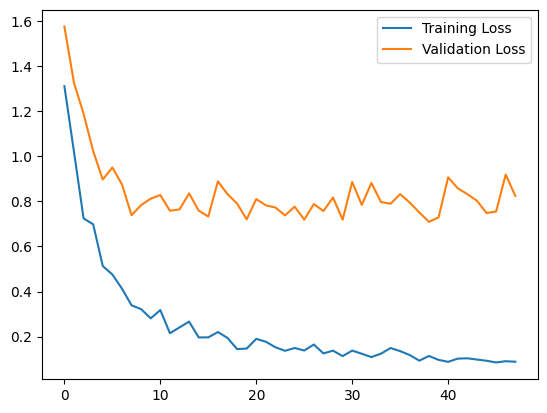

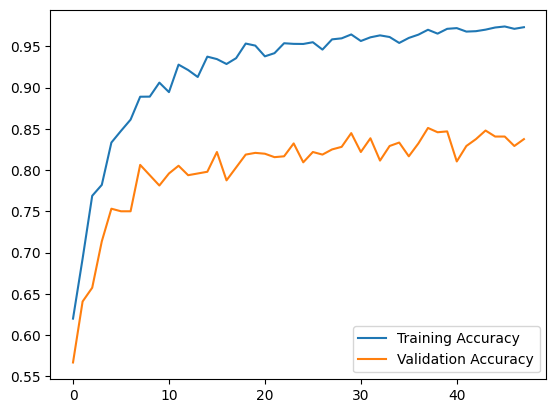

In [16]:
#plot learning curves
plt.figure()
plt.plot(step2_training_losses, label='Training Loss')
plt.plot(step2_validation_losses, label='Validation Loss')
plt.legend()
plt.savefig(os.path.join(output_path, "step2_loss.png"))

plt.figure()
plt.plot(step2_training_accuracies, label='Training Accuracy')
plt.plot(step2_validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.savefig(os.path.join(output_path, "step2_accuracy.png"))

In [17]:
preds, true, _ = evaluate(test_dataloader, step2_best_model, loss_fn)
print("Test accuracy: ", np.mean(preds == true))

Test accuracy:  0.8291666666666667
